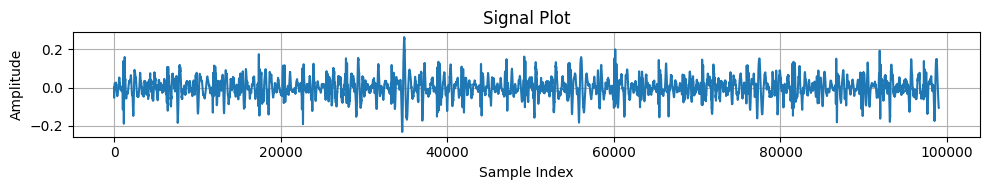

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.fileio import read_signal_wav, read_ticking_PCG
from processing.filtering import resample
from processing.process import pre_process_pcg

filename ='/home/sparc/Desktop/TH_alldata_fil/ic126_Dia3_Sit_63s.wav'
if filename.split('/')[-1][1] == 'v':
    collect = 2
elif filename.split('/')[-1][1] == 'c':
    collect = 2
else:
    collect = 1

pcg_data, fs = read_ticking_PCG(filename, channel=4, noise_mic=False, collection=collect)

pcg_data=pcg_data[1000:100000]
pcg_data = pre_process_pcg(pcg_data, fs, 20, 1000)
# Extract the actual array from the list

# Plot the signal
plt.figure(figsize=(10, 2))
plt.plot(pcg_data)
plt.title('Signal Plot')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
# plt.ylim(-0.12,0.12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def segment_signal_noise_multi_MedPow(
    multi_signal,
    frame_len_sec,
    fs_new,
    threshold,
    total_sig,
    nm,
    fig=0
):
    """
    Python version of MATLAB:
    segment_signal_noise_multi_MedPow.m

    Parameters
    ----------
    multi_signal : np.ndarray
        Shape (N,) or (N, C)
    frame_len_sec : float
        Frame length in seconds
    fs_new : int
        Sampling frequency
    threshold : float
        Energy threshold multiplier
    total_sig : int
        Number of signals (channels)
    nm : int
        1 = noise mic, 0 = PCG
    fig : int
        Ignored (MATLAB plotting flag)

    Returns
    -------
    ind_flag_m : np.ndarray or list of np.ndarray
        Each array is (K,2) [start, end] indices (0-based)
    """

    # Ensure 2D: (samples, channels)
    if multi_signal.ndim == 1:
        multi_signal = multi_signal[:, None]

    frame_len_sample = int(round(frame_len_sec * fs_new))
    ind_flag_m = [] if total_sig > 1 else None

    for c in range(total_sig):
        signal = multi_signal[:, c]
        len_signal = len(signal)

        no_frames = int(np.floor(len_signal / frame_len_sample))
        En = np.zeros(no_frames)

        # ---- Frame energy ----
        for i in range(no_frames):
            start = i * frame_len_sample
            end   = start + frame_len_sample-1
            sig = signal[start:end+1]
            En[i] = np.sum(sig ** 2)

        # ---- Median energy (exclude edges) ----
        if len(En) > 2:
            med_val = float(np.median(En[1:-1].astype(np.float64)))
        else:
            med_val = np.median(En)

        ind_flag = []

        # ---- Thresholding ----
        
        j = 0  # Python uses 0-based indexing

        for i in range(len(En)):  # i = 0, 1, ..., len(En)-1
            if En[i] > threshold * med_val:
                start = i * frame_len_sample 
                end = (i + 1) * frame_len_sample-1
                ind_flag.append([start, end])
                j += 1

        #ind_flag = np.array(ind_flag, dtype=int)

        # ---- NM-specific rule: add max-energy frame ----
        if nm == 1 and len(En) > 0:
            k = np.argmax(En)
            start = k * frame_len_sample
            end   = (k + 1) * frame_len_sample
            ind_flag.append([start, end])
        
        ind_flag = np.array(ind_flag, dtype=int)

        #ind_flag_m.append(ind_flag)

    # Store results
        if total_sig > 1:
            ind_flag_m.append(ind_flag)
        else:
            ind_flag_m = ind_flag

    return ind_flag_m

ind = segment_signal_noise_multi_MedPow(pcg_data,2.5,fs,2.5,1,0,0)

ind

array([], dtype=int64)